# Практика: линейные алгоритмы
В этом ноутбуке мы применим линейные алгоритмы к задачам регрессии и классификации.
![alt text](https://drive.google.com/uc?id=1bb0aecCJLyVypWuU3yeAgfDt8VoGyP3u)

## Линейная регрессия

Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть:
$$ y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b,$$
где у - целевая переменная (что мы хотим предсказать), $x_i$ -- признак объекта х, $w_i$ -- вес i-го признака, b -- bias (смещение, свободный член)

Часто предполагают, что объект х содержит в себе фиктивный признак, который всегда равен 1, тогда параметр $b$ соответствует весу этого признака в итоговой модели. В этом случае формула принимает простой вид:
$$ y = <w, x>. $$

В матричной форме, в случае, когда у нас есть n объектов формулу можно переписать следующим образом:
$$ Y = Xw,$$
где Y --- вектор размера n, X --- матрица объекты-признаки размера $n \times k$, a w --- вектор весов размера k.

Решение по методу наименьших квадратов дает 
$$ w = (X^TX)^{-1}X^TY $$

### Загрузка датасета
Для начала загрузим набор данных, с которым мы будем работать. В библиотеке scikit-learn есть множество тренировочных наборов данных для освоения и проверки методов машинного обучения. Мы будем работать с датасетом Boston. Этот датасет описывает средние цены на недвижимость в микрорайонах Бостона в $1000. 
Примеры признаков микрорайона: количество преступлений на душу населения, процент старых домов в районе, среднее количество учеников на одного учителя и т.д.

![alt text](https://drive.google.com/uc?id=1uD19MPXfdXnNrvTU9rU2IO5cRlM4QfW7)

Стандартные наборы данных в scikit-learn находятся в модуле sklearn.datasets.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [2]:
house_data = load_boston()
print(house_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Выделение данных и анализ

Выделим матрицу объекты-признаки в переменную $X$, правильные ответы --- в переменную $y$. Используем библиотеку pandas. Для отображения информации о наборе данных используем функцию pd.describe, которая отображает полезные статистики из набора: средние значения признаков, минимум, максимум, медиану и др.

In [19]:
X = pd.DataFrame(house_data['data'], columns=house_data['feature_names'])
y = house_data['target']

X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Визуализируем распределения признаков в датасете

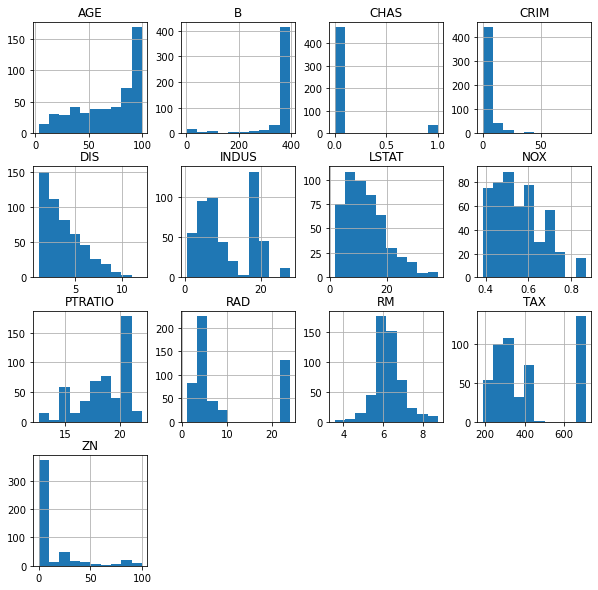

In [21]:
X.hist(X.columns, figsize=(10, 10));

Линейные алгоритмы часто сталкиваются с проблемой мультиколлинеарности признаков --- когда два или больше признаков оказываются близкими к линейно зависимым. Это, в частности, проявляется в том, что матрица $X$ становится необратимой, а, значит, в решении задачи линейной регрессией в формуле мы не можем вычислить $X^{-1}$. Эту проблему на практике обходят численными методами оптимизации, но решение задачи методом линейной регрессии по-прежнему может оказаться нестабильным. 

Проблему мультиколлинеарности устранить не так просто, но можно по крайней мере проверить, что никакие два признака не являются линейно зависимыми. В случае, если два признака оказываются линейно зависимыми, один из них (тот, который имеет меньшее влияние на целевую переменную $y$ может быть удалён из рассмотрения.

На практике линейную зависимость признаков можно выявить, посчитав матрицу корреляций признаков между собой. Сделать это нам поможет функция .corr() в padnas, а также модуль seaborn.

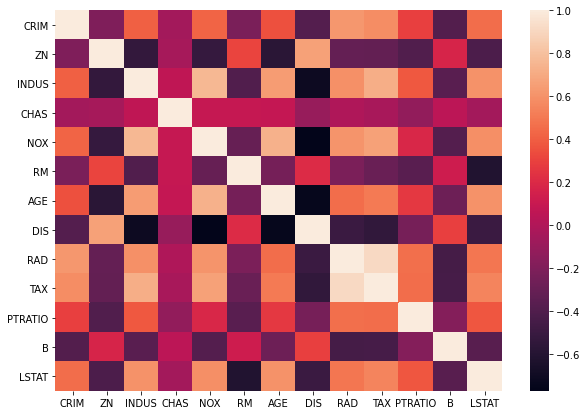

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(10,7))
sns.heatmap(X.corr())

Если два признака имеют слишком большую или слишком маленькую корреляцию, их целесообразно удалить из датасета. Здесь лишь два признака имеют высокую корреляцию --- около 0.8. Один из этих признаков можно было бы удалить из рассмотрения, но мы сейчас это делать не будем, так как 0.8 --- не критичное значение.

Разобьём данные на train и test в соотношении 70:30. Используем функцию sklearn.model_selection.train_test_split.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Линейные алгоритмы восприимчивы к масштабу данных: они работают лучше, если все признаки имеют примерно одинаковую дисперсию. Отнормируем данные с помощью объекта StandardScaler из модуля sklearn.preprocessing.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
np.std(X_train, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Обучение линейной регрессии

Теперь всё готово для обучения. Линейная регрессия находится в модуле sklearn.linear_model. Обучим линейную регрессию на X_train и предскажем значения на X_test. 

In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

Виуализируем получившиеся веса алгоритма.

<BarContainer object of 13 artists>

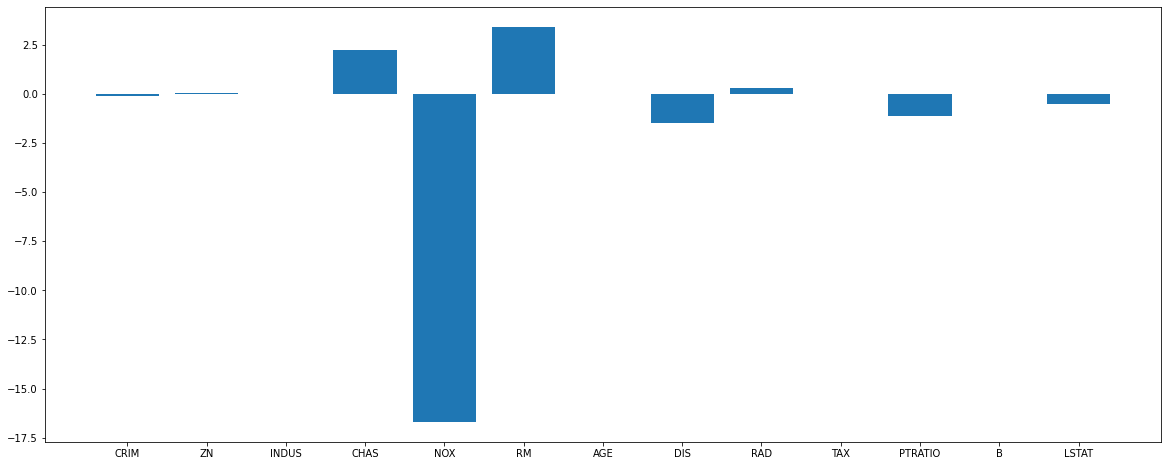

In [26]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.coef_)

### Оценка качества алгоритма

Для оценки качества работы алгоритма нам необходимы метрики. Мы посчитаем среднюю квадратичную ошиюбку: $$MSE = \frac{1}{n}\sum{(y_{true} - y_{pred})^2}$$ и среднюю абсолютную ошибку: $$MAE = \frac{1}{n}\sum{|y_{true} - y_{pred}|}.$$

Функции вычисления ошибок находятся в модуле sklearn.metrics.

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Train MSE: {}'.format(mean_squared_error(y_train, y_train_prediction)))
print('Test MSE: {}'.format(mean_squared_error(y_test, y_test_prediction)))

print('Train MAE: {}'.format(mean_absolute_error(y_train, y_train_prediction)))
print('Test MAE: {}'.format(mean_absolute_error(y_test, y_test_prediction)))

Train MSE: 20.422415409620065
Test MSE: 26.200364939186404
Train MAE: 3.22220953588971
Test MAE: 3.404142655828248


In [28]:
y.mean()

22.532806324110677

### Кросс-валидация
Иногда просто разбиение на обучающую и тестовую выборки не даёт точного прогноза оценки ошибки, ведь обученный алгоритм может сильно меняться в зависимости от обучающей выборки. Чтобы нивелировать эффект конкретной обучающей выборки, используют так называему кросс-валидацию. Идея кросс-валидации состоит в том, чтобы разбить все данные на несколько одинаковых частей, поочерёдно используя каждую часть как test, а оставшийся датасет --- как train. На каждом из экспериментов вычисляют тестовую ошибку, затем результат усредняют по всем экспериментам.

![alt text](https://drive.google.com/uc?id=11TVMLDP-oc6-HyO7a_Jteyvpb_KzqaM5)

Выполним эту схему на нашем датасете. Кросс-валидация находится в модуле sklearn.model_selection.

In [29]:
from sklearn.model_selection import cross_val_score

result = cross_val_score(estimator=LinearRegression(), X=X, y=y, scoring='neg_mean_absolute_error', cv=5)
result

array([-2.62190565, -3.90725478, -4.386606  , -5.57073637, -4.76333993])

In [30]:
print("Average MAE is {}, standard deviation of MAE is {}".format(-result.mean(), result.std()))

Average MAE is 4.249968544192542, standard deviation of MAE is 0.9792537069067557


## Логистическая регрессия
Логистическая регрессия --- это линейный алгоритм классификации, основанный на оптимизации логистической функции потерь:

$$-\sum\limits_{y^i = 1} \ln \sigma(\langle x^i, w \rangle) - \sum\limits_{y^i = -1} \ln (1 - \sigma(\langle x^i, w \rangle)) \rightarrow \min\limits_{w}.$$

С помощью функции сигмоиды: 
$$\sigma(t) = \frac{1}{1 + e^{-t}}$$ можно вычислять вероятность принадлежности объекта классу 1 против класса -1 по формуле $$p(\text{класс 1}) = \sigma(\langle x, w \rangle).$$

В данном разделе семинара мы проведём эксперимент с логистической регрессией на искусственных данных. Для начала визуализируем сигмоиду.

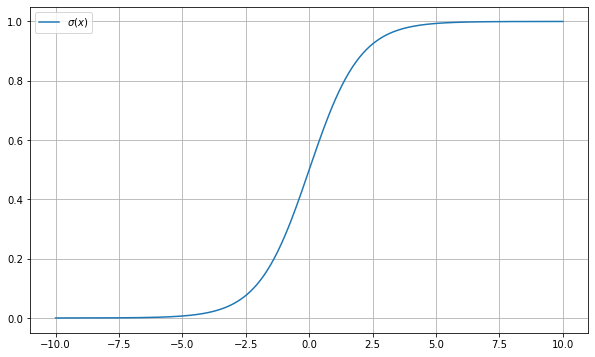

In [31]:
grid = np.linspace(-10, 10, 300)

plt.figure(figsize=(10,6))
plt.plot(grid, 1. / (1 + np.exp(-grid)), label='$\sigma(x)$')
plt.legend()
plt.grid(True)
plt.show()

### Генерация данных

Создадим два кластера с данными для решения задачи классификации c помощью sklearn.datasets.make_blobs.

In [32]:
from sklearn.datasets import make_blobs

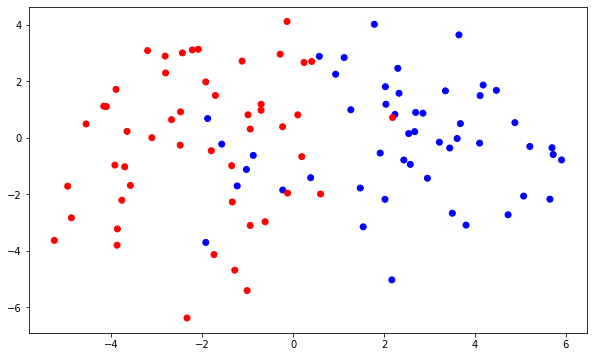

In [33]:
colors = ("red", "blue")
X, y = make_blobs(n_samples=100, centers=[[-2,0], [2,0]], random_state=20, cluster_std=2)

colored_y = np.zeros(y.size, dtype=str)
for i in range(2):
    colored_y[y == i] = colors[i]

plt.figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)

### Обучение логистической регрессии

Обучим логистическую регрессию на наших данных. Модель можно найти всё в том же модуле sklearn.linear_model.

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

Выведем обученные параметры алгоритма.

In [36]:
print("Вектор w равен {}, свободный член w равен {}.".format(model.coef_[0], model.intercept_[0]))

Вектор w равен [ 1.13278866 -0.13748293], свободный член w равен -0.11995755619445762.


Визуализируем предсказания

In [37]:
#Параметры визуализации

x_min, x_max = -12, 12
y_min, y_max = -10, 10
h = 0.05
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

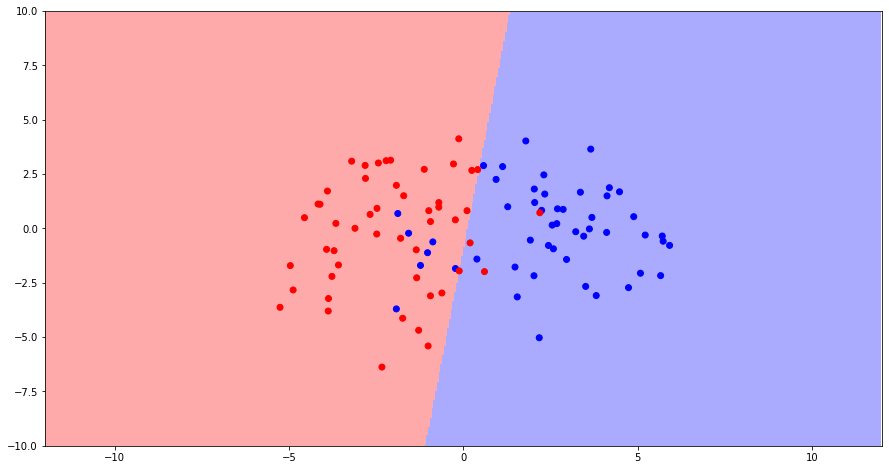

In [38]:
plt.figure(figsize=(15,8))

plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

Более подробно про практику использования линейных алгоритмов: https://scikit-learn.org/stable/modules/linear_model.html